In [1]:
import cv2
import glob
import time
import locale
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.python import keras
from keras.models import Model
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import concatenate
from keras.layers.core import Dropout
from keras.callbacks import TensorBoard
from keras.models import model_from_yaml
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
#from keras.layers.normalization import BatchNormalization

In [2]:
textfile_path = "C:\\Users\\HP\\Desktop\\Barcelona\\Term3\\DeepLearningApplication\\term_paper\\Houses Dataset\\HousesInfo.txt"

col = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

text_data = pd.read_csv(textfile_path, sep = ' ', names = col)

text_data.head(10)

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
5,4,5.0,4581,85266,1249000
6,3,4.0,2544,85262,799000
7,4,5.0,5524,85266,1698000
8,3,4.0,4229,85255,1749000
9,4,5.0,3550,85262,1500000


In [3]:
# we reduce the number of images to speed up the training

n = 200

text_data = text_data[:n]

p_max = text_data['price'].max()

In [4]:
proportion = round(n*0.75)
other_proportion = n - proportion

y_train = text_data[:proportion]
y_test = text_data[-other_proportion:]

In [5]:
def image_split(df):
    images = []

    for i in df.index.values:
        housePaths = sorted(list(glob.glob("Houses Dataset/{}_*".format(i+1))))

        inputImages = []
        outputImage = np.zeros((64,64,3), dtype = "uint8")
                
        for housePath in housePaths : 
            image = cv2.imread(housePath)
            image = cv2.resize(image,(32,32))
            inputImages.append(image)

            if len(inputImages) >= 4: 
                outputImage[0:32, 0:32] = inputImages[0]
                outputImage[0:32, 32:64] = inputImages[1]
                outputImage[32:64, 32:64] = inputImages[2]
                outputImage[32:64, 0:32] = inputImages[3]
            
                images.append(outputImage)

    return images
        

In [6]:
X_train = image_split(y_train)
X_test = image_split(y_test)

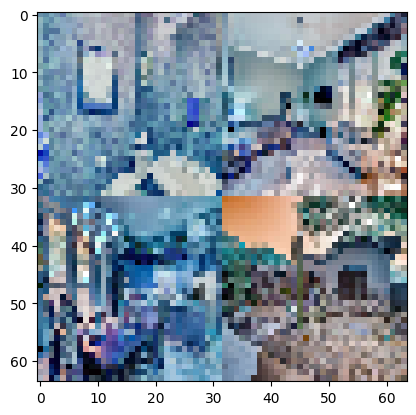

In [7]:
# visualise the data
plt.imshow(X_train[0])
plt.show()

In [8]:
# X are the images we use for classifications, 
X_train = np.multiply(X_train, (1/255))
X_test = np.multiply(X_test, (1/255))

# y is the price of the house corresponding to house i
y_train = np.stack(y_train['price'])
y_train = y_train / p_max
y_test = np.stack(y_test['price'])
y_test = y_test / p_max

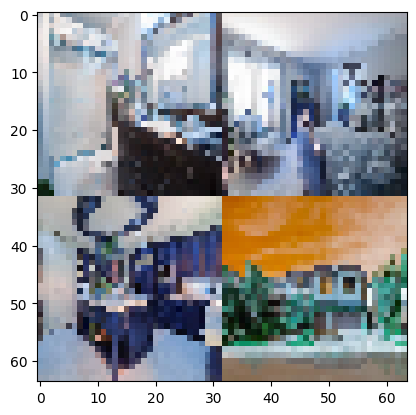

In [9]:
# visualisation pt. II
plt.imshow(X_test[0])
plt.show()

In [10]:
# check dimensions:
print(f'{X_train.shape} is the dimension of X')

print(f'{y_train.shape} is the dimension of y')

(150, 64, 64, 3) is the dimension of X
(150,) is the dimension of y


In [11]:
# define U-Net
def encoder(imp, filters, kernel_size=(3, 3), padding="same", strides=1):
    # imp = input, filters = reduce/compact the pixel dimesion
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(imp)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    # returns the first layer which is fed to the decoders (see image)
    # p is the encoder block
    return c, p

def decoder(imp, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    imp = imput
    skip = the layer from the encoder block that is concatenated (see blue line in graphic)
    filter = reduce/compact the pixel dimesion
    '''
    # concatenate imput and encoder layer
    us = keras.layers.UpSampling2D((2, 2))(imp)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(imp, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(imp)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [12]:
def u_net():
    f = [2, 4, 8, 16, 32, 64]
    inputs = keras.layers.Input((64, 64, 3))

    p0 = inputs
    c1, p1 = encoder(p0, f[0])  # 64 -> 32
    c2, p2 = encoder(p1, f[1])  # 32 -> 16
    c3, p3 = encoder(p2, f[2])  # 16 -> 8
    c4, p4 = encoder(p3, f[3])  # 8 -> 4
    c5, p5 = encoder(p4, f[4])  # 4 -> 2

    bn = bottleneck(p5, f[5])

    u1 = decoder(bn, c5, f[4])  # 2 -> 4
    u2 = decoder(u1, c4, f[3])  # 4 -> 8
    u3 = decoder(u2, c3, f[2])  # 8 -> 16
    u4 = decoder(u3, c2, f[1])  # 16 -> 32
    u5 = decoder(u4, c1, f[0])  # 32 -> 64

    flatten = keras.layers.Flatten()(u5)  # Flatten the feature maps
    dense1 = keras.layers.Dense(256, activation="relu")(flatten)  # Add a dense layer
    outputs = keras.layers.Dense(1, activation="linear")(dense1)  # Output a single number

    model = keras.models.Model(inputs, outputs)
    
    return model

In [13]:
model = u_net()  # Replace height, width, and channels with your actual input dimensions
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])  # Choose an appropriate loss function and metrics
model.summary()  # Display the model summary

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 2)    56          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 2)    38          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 2)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
history = model.fit(X_train, y_train, batch_size=2, epochs=50)

Epoch 1/50
75/75 [==============================] - 5s 49ms/step - loss: 1.6582 - mae: 0.4027
Epoch 2/50
75/75 [==============================] - 4s 60ms/step - loss: 0.0201 - mae: 0.0981
Epoch 3/50
75/75 [==============================] - 4s 53ms/step - loss: 0.0202 - mae: 0.1023
Epoch 4/50
75/75 [==============================] - 4s 49ms/step - loss: 0.0174 - mae: 0.0934
Epoch 5/50
75/75 [==============================] - 4s 51ms/step - loss: 0.0151 - mae: 0.0849
Epoch 6/50
75/75 [==============================] - 4s 50ms/step - loss: 0.0120 - mae: 0.0755
Epoch 7/50
75/75 [==============================] - 4s 54ms/step - loss: 0.0067 - mae: 0.0589
Epoch 8/50
75/75 [==============================] - 4s 52ms/step - loss: 0.0147 - mae: 0.0856
Epoch 9/50
75/75 [==============================] - 4s 49ms/step - loss: 0.0114 - mae: 0.0832
Epoch 10/50
75/75 [==============================] - 3s 45ms/step - loss: 0.0073 - mae: 0.0650
Epoch 11/50
75/75 [==============================] - 4s 49m

In [15]:
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error

# Assuming you have the prediction vector stored in 'y_pred' and the ground truth values in 'y_test'
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

MSE: 0.018266767037359865


In [ ]:
def CNN():
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation= 'relu', padding='same', input_shape = (64,64,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3), activation= 'elu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, (3,3), activation= 'elu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #Fully connected NN
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation= 'relu'))
    
    return model